<a href="https://colab.research.google.com/github/cloudhood/learning-basics/blob/main/notebooks/CV_with_Tensorflow_2_Part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Computer Vision: Training a Dense Neural Network](https://learning.oreilly.com/scenarios/computer-vision-training/9781492094425/)


So far, we have been working with the `Dense` layer for classifying images. But in practice, we use a **two special-layer pair** prior to using a `Dense` layer — a `convolution` layer and a `maximum pooling` layer (or an `average pooling` layer, although newer models all use maximum pooling layers). 

It's common to see many pairs of `convolution` layers and `maximum pooling` layers prior to using `dense` layers.

When many pairs of these layers are followed by a flatten layer and then a few dense layers, it's commonly called a **Convolution Neural Network (CNN)**. Convolutional neural networks are a kind of **feed-forward** neural network whose artificial neurons can respond to a part of the **surrounding cells** in the coverage range, something a dense layer cannot achieve by itself.

![CNN](https://miro.medium.com/max/1100/1*vkQ0hXDaQv57sALXAJquxA.jpeg)

In this scenario we will replicate a simple CNN called `LeNet-5`, which has a simple architecture.

In [1]:
!pip install numpy tensorflow --upgrade &> /dev/null

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist

There are `60,000` and `10,000` images in the training and test sets respectively.

In [10]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)


(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


We have two problems:

1. A convolution layer expects image in the shape `(size, row, width, filters)` . The images here are just black and white, so there is only 1 filter (cf. RGB images which have 3). We need to increase our image shape by one dimension.

2. `LeNet-5` expects images of size `32 x 32` but our images are of size `28 x 28`. 

Potential solutions include stretching or padding the images. 

## Normalization, dimension expansion and data padding


In [11]:
print("Few pixel values BEFORE normalization: \n", 
      train_images[0,20:26,20:26])
train_images  = train_images / 255.0
test_images = test_images / 255.0
print("\nFew pixel values AFTER normalization: \n", 
      train_images[0,20:26,20:26])

Few pixel values BEFORE normalization: 
 [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]

Few pixel values AFTER normalization: 
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [12]:
## Expand
train_images = np.expand_dims(train_images,-1)
test_images = np.expand_dims(test_images,-1)

In [13]:
print(train_images.shape)
print(test_images.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [14]:
# Padding
# Add two rows of zeros above and below the image.
# Add two rows of zeros to the left and right of the image. 
train_images = np.pad(
    train_images, 
    ((0,0),(2,2),(2,2),(0,0)), 
    'constant'
)
test_images = np.pad(
    test_images, 
    ((0,0),(2,2),(2,2),(0,0)), 
    'constant'
)

In [15]:
print(train_images.shape)
print(test_images.shape)

(60000, 32, 32, 1)
(10000, 32, 32, 1)


## Model
The '5' in `LeNet-5` corresponds to 5 layers, or rather 5 trainable layers (Max Pooling layers and Flatten layers have no trainable parameters). 

The following are the layers:

1. `Convolution` Layer 1 + `Avg. Pool` Layer 1
2. `Convolution` Layer 2 + `Avg. Pool` Layer 2
3. `Flatten` Layer + `Dense` Layer 1
4. `Dense` Layer 2
5. `Dense` Layer 3 (Output layer)


This model has just over 81k parameters compared to 200k in the last scenario. But will it achieve a higher level of accuracy? Let's find out...


In [17]:
# filters: dimensionality of output space. 
# kernel_size: Height and width of convolution window
# strides: Stride of the convolution window
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        filters=6, 
        kernel_size=(3, 3), 
        strides=(1, 1), 
        activation='relu', 
        input_shape=(32, 32, 1)
    ),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.Conv2D(
        filters=16, 
        kernel_size=(3, 3),
        strides=(1, 1),  
        activation='relu'
    ),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=120, activation='relu'),
    tf.keras.layers.Dense(units=84, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

In [18]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 6)         60        
                                                                 
 average_pooling2d_2 (Averag  (None, 15, 15, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 16)        880       
                                                                 
 average_pooling2d_3 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 576)               0         
                                                                 
 dense_3 (Dense)             (None, 120)              

In [19]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
model.fit(
    train_images, 
    train_labels, 
    epochs=5, 
    batch_size=1024, 
    validation_data=(test_images, test_labels)
)

Epoch 1/5
59/59 [==============================] - 27s 436ms/step - loss: 1.1997 - accuracy: 0.6645 - val_loss: 0.3963 - val_accuracy: 0.8838
Epoch 2/5
59/59 [==============================] - 22s 366ms/step - loss: 0.3302 - accuracy: 0.9027 - val_loss: 0.2684 - val_accuracy: 0.9213
Epoch 3/5
59/59 [==============================] - 21s 356ms/step - loss: 0.2469 - accuracy: 0.9257 - val_loss: 0.2018 - val_accuracy: 0.9400
Epoch 4/5
59/59 [==============================] - 22s 376ms/step - loss: 0.1928 - accuracy: 0.9433 - val_loss: 0.1541 - val_accuracy: 0.9522
Epoch 5/5
59/59 [==============================] - 23s 399ms/step - loss: 0.1536 - accuracy: 0.9553 - val_loss: 0.1266 - val_accuracy: 0.9621


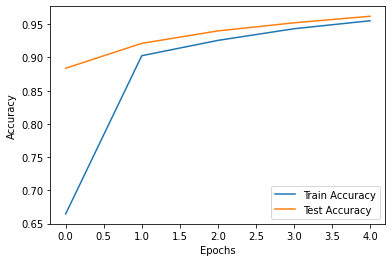

In [24]:
plt.plot(model.history.history['accuracy'],label='Train Accuracy')
plt.plot(model.history.history['val_accuracy'],label='Test Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.savefig('accuracy_plot.png')
plt.show()



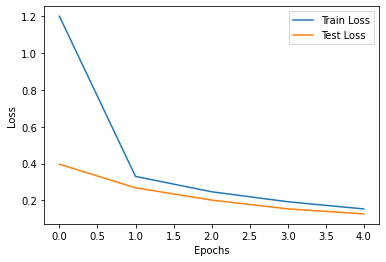

In [23]:
plt.close()
plt.plot(model.history.history['loss'],label='Train Loss')
plt.plot(model.history.history['val_loss'],label='Test Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.savefig('loss_plot.png')
plt.show()

In [25]:
# Weights of the layers are initialized randomly so results will vary.
# Overall, higher accuracy is achieved with fewer parameters compared
# to a pure Dense model.
model.evaluate(test_images, test_labels)



313/313 [==============================] - 6s 18ms/step - loss: 0.1266 - accuracy: 0.9621


[0.12664172053337097, 0.9621000289916992]